## Assignment 5 

-----
Kyle Groenewald

201710099

Sol Plaatje University

BSc. Hons in Data Science

-----

In [56]:
import pymc3 as pm
import arviz as az

import theano as T
import theano.tensor as tt
import theano.tensor.nlinalg

In [57]:
x = np.array([0, 0.1, 2, 4])
y = np.array([4, 0.9, 3.6, 5])

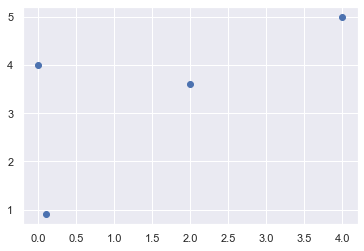

In [58]:
plt.scatter(x,y)
plt.show()

In [48]:
squared_distance = lambda x, y: np.array([[(x[i] - y[j])**2 for i in range(len(x))] for j in range(len(y))])

In [68]:
l = 1
smooth = 20

In [73]:
x_prior = np.linspace(-2,7,smooth)

In [50]:
X = x[:, None]

In [60]:
with pm.Model() as model_gpr:
    
    # kernel
    cov = pm.gp.cov.ExpQuad(1, ls=l)
    
    ϵ = pm.HalfCauchy('ϵ', 3)
    
    gp = pm.gp.Latent(cov_func=cov)
    
    f = gp.prior("f", X=X)

In [61]:
with model_gpr:
    approx = pm.fit()

Finished [100%]: Average Loss = 0.036453


In [62]:
trace = approx.sample(10000)

In [63]:
az.summary(trace)

C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
arviz - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
f_rotated_[0],0.005,1.068,-1.983,2.014,0.011,0.008,9703.0,9539.0,NaN
f_rotated_[1],0.014,1.070,-2.011,1.985,0.011,0.008,10118.0,9677.0,NaN
f_rotated_[2],-0.025,1.077,-1.989,1.992,0.011,0.008,9900.0,9727.0,NaN
f_rotated_[3],0.015,1.063,-2.045,1.955,0.011,0.008,10002.0,9833.0,NaN
ϵ,8.796,21.704,0.012,29.465,0.217,0.153,9740.0,9921.0,NaN
f[0],0.005,1.068,-1.983,2.014,0.011,0.008,9703.0,9539.0,NaN
f[1],0.006,1.070,-1.997,1.998,0.011,0.008,9724.0,9774.0,NaN
f[2],-0.018,1.078,-2.026,1.978,0.011,0.008,9888.0,10130.0,NaN
f[3],0.012,1.062,-1.969,2.009,0.011,0.008,9954.0,9754.0,NaN


In [64]:
with model_gpr:
    sample_trace = pm.sample(1000)

<ipython-input-64-3a109496f7a6>:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  sample_trace = pm.sample(1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\ProgramData\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [f_rotated_, ϵ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.


<ipython-input-65-a160152aab47>:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(sample_trace)
C:\ProgramData\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


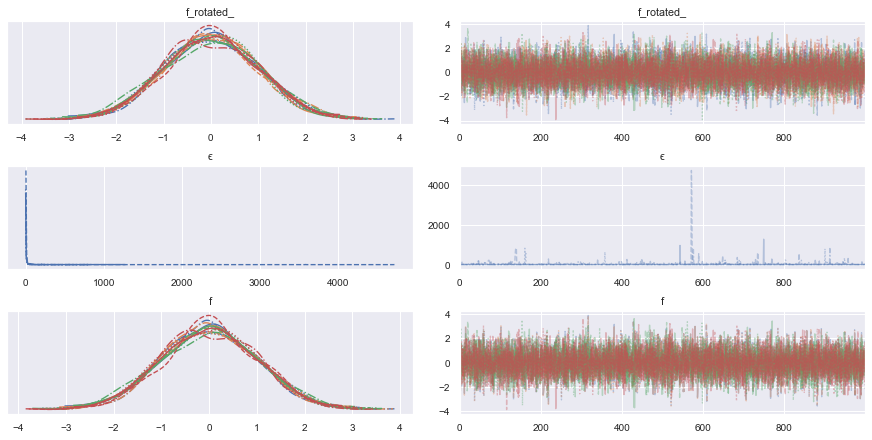

In [65]:
pm.traceplot(sample_trace)
plt.show()

In [69]:
X_new = np.linspace(-2, 7, smooth)[:,None]

In [66]:
with model_gpr:
    pred_samples = pm.sample_posterior_predictive(trace, samples=1000)

C:\ProgramData\Anaconda3\lib\site-packages\pymc3\sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


In [85]:
def sq_exp_kernel(x0, x1, tau, l):
    return tau**2 * np.exp(-np.subtract.outer(x0, x1)**2 / l**2)

In [86]:
K = sq_exp_kernel(x, x, trace['f_rotated_'].mean(), trace['f'].mean())
K_pred = sq_exp_kernel(x_prior, x, trace['f_rotated_'].mean(), trace['f'].mean())
K_pred_pred = sq_exp_kernel(x_prior, x_prior, trace['f_rotated_'].mean(), trace['f'].mean())

In [87]:
y_pred = K_pred.dot(np.linalg.solve(K + trace['ϵ'].mean()**2 * np.eye(len(x)), y))

cov_pred = K_pred_pred - K_pred.dot(np.linalg.solve(K + trace['ϵ'].mean()**2 * np.eye(len(x)), K_pred.T))
sigma_pred = np.sqrt(cov_pred.diagonal())
y_pred_low = y_pred - sigma_pred * sp.stats.norm.isf(0.025)
y_pred_high = y_pred + sigma_pred * sp.stats.norm.isf(0.025)

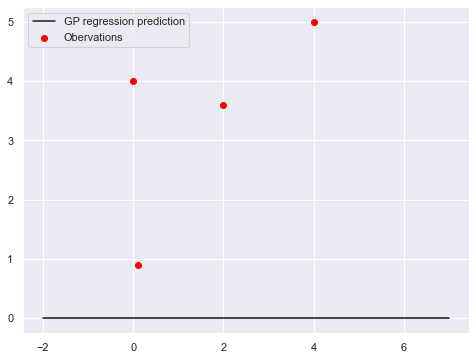

In [88]:
fig, ax = plt.subplots(figsize=(8, 6))

plot_x = x_prior

ax.fill_between(plot_x, y_pred_low, y_pred_high, color='k', alpha=0.25)
ax.plot(plot_x, y_pred,
        c='k', label='GP regression prediction')
ax.scatter(x, y,
           c='red', label='Obervations')

ax.legend()
plt.show()